In [28]:
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os
import matplotlib.pyplot as plt

In [22]:
device = torch.device(
    'mps' if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available()
    else 'cpu'
)
print('device is set to:', device)

device is set to: mps


In [23]:
# data_dir?
data_dir = '../data'

# 1.Compose meaning?
# 2.Normalize part
transform = transforms.Compose([
    transforms.Pad(2),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081)) 
])

train_ds = datasets.MNIST(
    root=data_dir,
    train=True,
    download=True,
    transform=transform
)

train_loader = DataLoader(
    train_ds,
    batch_size=128,
    shuffle=True,
    num_workers=0
)

test_ds = datasets.MNIST(
    root=data_dir,
    train=False,
    download=True,
    transform=transform
)

test_loader = DataLoader(
    test_ds,
    batch_size=256,
    shuffle=False,
    num_workers=0
)

# Cell 2 Model Definition

In [24]:
class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool1 = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.AvgPool2d(2, 2)

        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = torch.tanh(self.conv1(x))
        x = self.pool1(x)
        x = torch.tanh(self.conv2(x))
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

## Cell 3 Loss&Optimizer

In [25]:
model = LeNet5().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.01,
    momentum=0.9
)

## Cell 4 One epoch

In [26]:
# 1. model.train() model.eval() train_loader?
# 2. loss.backward() -- optimizer.step() 
# 3. running_loss
# 4. preds = logits.argmax(dim=1)
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()

    running_loss = 0.0
    correct = 0
    total = 0

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        logits = model(xb)
        loss = criterion(logits, yb)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        batch_size = xb.size(0)
        running_loss += loss.item() * batch_size

        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += batch_size

    avg_loss = running_loss / total
    train_acc = correct / total
    return avg_loss, train_acc

def evaluate(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for xb, yb in data_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            preds = logits.argmax(dim=1)

            correct += (preds == yb).sum().item()
            total += xb.size(0)
    return correct / total



In [27]:
avg_loss, train_acc = train_one_epoch(
    model,
    train_loader,
    criterion,
    optimizer,
    device
)
test_acc = evaluate(model, test_loader, device)

print('train avg loss:', avg_loss)
print('train accuracy:', train_acc)
print('test accuracy:', test_acc)

print('--update line--')
num_epochs = 5
history = {
    'train_loss': [],
    'train_acc': [],
    'test_acc': []
}

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    test_acc = evaluate(model, test_loader, device)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_acc'].append(test_acc)

    print(f'epoch {epoch:02d} | train_loss={train_loss:.4f} | train_acc={train_acc:.4f} | test_acc={test_acc:.4f}')

train avg loss: 0.6281498613278071
train accuracy: 0.8158333333333333
test accuracy: 0.9446
--update line--
epoch 01 | train_loss=0.1448 | train_acc=0.9579 | test_acc=0.9718
epoch 02 | train_loss=0.0909 | train_acc=0.9730 | test_acc=0.9800
epoch 03 | train_loss=0.0700 | train_acc=0.9790 | test_acc=0.9829
epoch 04 | train_loss=0.0585 | train_acc=0.9824 | test_acc=0.9823
epoch 05 | train_loss=0.0495 | train_acc=0.9851 | test_acc=0.9844


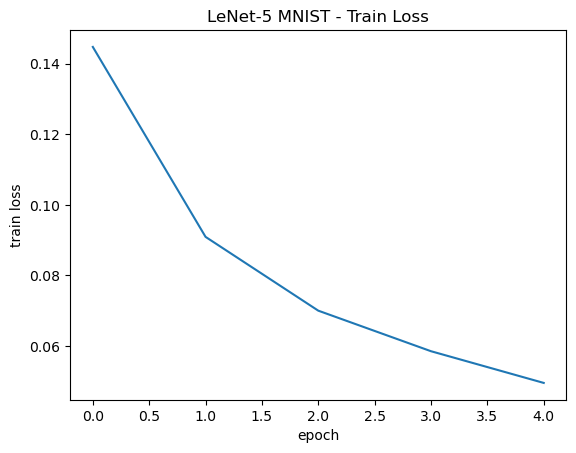

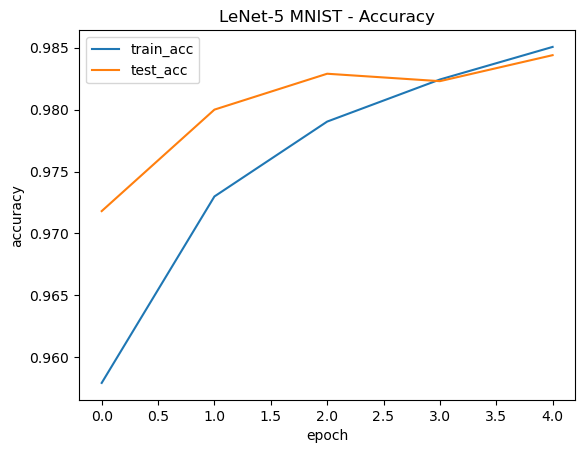

In [29]:
os.makedirs('../outputs', exist_ok=True)

plt.figure()
plt.plot(history['train_loss'])
plt.xlabel('epoch')
plt.ylabel('train loss')
plt.title('LeNet-5 MNIST - Train Loss')
plt.savefig('../outputs/train_loss.png', dpi=200)
plt.show()

plt.figure()
plt.plot(history['train_acc'], label='train_acc')
plt.plot(history['test_acc'], label='test_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('LeNet-5 MNIST - Accuracy')
plt.legend()
plt.savefig('../outputs/accuracy.png', dpi=200)
plt.show()


In [30]:
torch.save(model.state_dict(), '../outputs/lenet5_mnist.pt')
print('saved to ../outputs/lenet5_mnist.pt')

saved to ../outputs/lenet5_mnist.pt
